In [1]:
import glob
import os
import numpy as np
import pickle
import random
import re
import seaborn
import string
import time

from typing import List, Tuple, Dict
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

DATASET_PATH = 'en-wiki/text'

PATTERN = { # Removes @mentions, urls, tags, and simple faces
    'url': re.compile(r'([^A-Za-z0-9] \t)|(\w+:\/\/\S+)|(w{3}\.\S+)'), # remove URLs
    'num': re.compile(r'(\d{2}/\d{2}/\d{2,4})|(\$0?\.?\d+)|([0-9]+)'), # remove numbers
    'doc_string_1': re.compile(r'<doc.*>'), # remove start doc xml string
    'doc_string_2': re.compile(r'</doc>'), # remove closing doc xml string
    'punkt_space': re.compile(r'([/.,!?(){}*:\+=&;"])'), # put spaces around punctuation
    'punkt_remove': re.compile(r'[^A-Za-z-.,";!?()=:&*[]]') # remove unwanted punctuation
    
}

CACHED_STOPWORDS = stopwords.words('english')
CACHED_STEMMER = SnowballStemmer('english')

In [2]:
def load_dataset(path: str) -> str:
    print("Loading dataset...")
    data = ''
    for file_path in glob.glob(path + '/*/*'):
        with open(file_path, 'r') as f:
            data += f.read()
    return data

In [3]:
def clean_text(text: str, remove_stopwords: bool=False, stem: bool=False) -> str:
    print("Cleaning text...")
    start = time.time()
    
    text = text.lower()
    for name, pattern in PATTERN.items():
        if name != 'punkt_space':
            text = re.sub(pattern,'', text)
        else:
            text = re.sub(pattern, r' \1 ', text) 
    
    if remove_stopwords:
        text = ' '.join([word for word in text.split() if word not in CACHED_STOPWORDS])
    
    if stem:
        text = ' '.join([CACHED_STEMMER.stem(word) for word in text.split()])
        
    text = text.strip()
    
    end = time.time()
    print("Finished cleaning...took {:.4f} seconds".format(end-start))
    return text

In [4]:
def subsample_vocab(text: List[str], word_counts: Dict, count_threshold:int=10) -> Tuple[List[str], Dict]:
    print("Decreasing vocabulary size...")
    vocab_size = len(word_counts)
    vocab = set([word for word, count in word_counts.items() if count > count_threshold])
    text = [word if word in vocab else 'UNK' for word in text]
    word_counts = Counter(text)
    print("Finished...{:.2f}% reduced".format((1 - len(vocab)/vocab_size) * 100))
    return text, word_counts

In [5]:
def subsample_text(text: List[str], word_counts: Dict, threshold: float=1e-3) -> List[str]:
    print("Negative subsampling text...")
    total_count = sum(word_counts.values())
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    
    text = [word for word in text if random.random() < (1 - p_drop[word])]
    return text

In [6]:
def create_lookup_tables(text: List[str], word_counts: Dict) -> Tuple[Dict, Dict]:
    """
    Create lookup tables for vocabulary
    
    :param text, list: the text
    """
    
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    
    vocab_to_int = {word: i for i, word in enumerate(vocab, 0)}
    int_to_vocab = {i: word for i, word in enumerate(vocab, 0)}
    
    return vocab_to_int, int_to_vocab

In [7]:
text = clean_text(load_dataset(DATASET_PATH), True, True).split()

Loading dataset...
Cleaning text...
Finished cleaning...took 396.0752 seconds


In [8]:
word_counts = Counter(text)

print("Total words: {}".format(len(text)))
print("Unique words: {}".format(len(word_counts)))

Total words: 28815566
Unique words: 444574


In [9]:
text, word_counts = subsample_vocab(text, word_counts, 20)

print("Total words: {}".format(len(text)))
print("Unique words: {}".format(len(word_counts)))

Decreasing vocabulary size...
Finished...91.77% reduced
Total words: 28815566
Unique words: 36604


In [10]:
text = subsample_text(text, word_counts)

print("Total words: {}".format(len(text)))
print("Unique words: {}".format(len(word_counts)))

Negative subsampling text...
Total words: 22094297
Unique words: 36604


In [11]:
vocab_to_int, int_to_vocab = create_lookup_tables(text, word_counts)

In [12]:
sample_text = text[:20]
sample_text_to_int = [vocab_to_int[word] for word in sample_text]

print("Tokenized: \'{}\'\n".format(' '.join(sample_text)))
print("To Ints: {}\n".format(sample_text_to_int))

assert([int_to_vocab[word_i] for word_i in sample_text_to_int] == sample_text)

Tokenized: 'motörhead motörhead english rock band form june bassist singer songwrit ian fraser " lemmi sole constant member guitarist larri walli'

To Ints: [11024, 11024, 189, 541, 360, 27, 411, 5204, 1892, 4940, 4877, 6546, 2, 10836, 1978, 1071, 89, 3324, 5088, 9871]



In [13]:
int_text = np.array([vocab_to_int[word] for word in text], dtype=int)

#### Save Preprocessed Data

In [14]:
pickle.dump((int_text, vocab_to_int, int_to_vocab), open('preprocess.enwiki.p', 'wb'))

# Checkpoint

In [1]:
import math
import numpy as np
import pickle
import random
import seaborn
import tensorflow as tf
import time

from typing import List, Tuple, Dict

#### Load Data

In [2]:
int_text, vocab_to_int, int_to_vocab = pickle.load(open('preprocess.enwiki.p', mode='rb'))
int_text = int_text.tolist()

In [3]:
print("Total words: {}".format(len(int_text)))
print("Unique words: {}".format(len(vocab_to_int)))

Total words: 22094297
Unique words: 36604


##### Utility functions for training

In [4]:
def get_target(words: List[int], idx:int, window_size:int=5) -> List[int]:
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [5]:
def get_batches(words: List[int], batch_size:int, window_size:int=5) -> Tuple[List[int], List[int]]:
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

## Build Word Embedding Graph

#### Builder functions

In [6]:
def get_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    
    :return: Tuple(input, targets) tf placeholders
    """
    input_data = tf.placeholder(tf.int32, [None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_data, targets, learning_rate

In [7]:
def get_embed(input_data, vocab_size: int, embed_dim: int) -> Tuple:
    """
    Create embedding for <input_data>.
    :param input_data: TF placeholder for text input.
    :param vocab_size: Number of words in vocabulary.
    :param embed_dim: Number of embedding dimensions
    :return: Embedded input.
    """
    embedding = tf.Variable(tf.random_uniform((vocab_size, embed_dim), -1.0, 1.0), name="embedding")
    embed = tf.nn.embedding_lookup(embedding, input_data)
    return embedding, embed

In [8]:
def get_output_layer(vocab_size: int, embed_dim: int) -> Tuple:
    softmax_w = tf.Variable(tf.truncated_normal((vocab_size, embed_dim), stddev=1.0 / math.sqrt(embed_dim)))
    softmax_b = tf.Variable(tf.zeros(vocab_size))
    
    return softmax_w, softmax_b

#### Network Parameters

In [9]:
vocab_size = len(int_to_vocab)
embed_dim = 300 # embed features
n_sampled = 64 # number of negative samples

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100

# Validation From Thushan Ganegedara's implementation
# pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
valid_examples = np.append(valid_examples, 
                           random.sample(range(1000,1000+valid_window), valid_size//2))

#### Build The Graph

In [10]:
train_graph = tf.Graph()

with train_graph.as_default():
    input_data, targets, lr = get_inputs()
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    embedding, embed = get_embed(input_data, vocab_size, embed_dim)
    softmax_w, softmax_b = get_output_layer(vocab_size, embed_dim)
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      targets, embed,
                                      n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)
    
    
    # Perform validation check
    ## We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

### Train

In [11]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


#### Hyperparemters

In [12]:
epochs = 10
batch_size = 1000
window_size = 10
learning_rate = 1e-3

In [ ]:
with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
    for e in range(1, epochs + 1):
        batches = get_batches(int_text, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            feed = {
                input_data: x,
                targets: np.array(y)[:, None],
                lr: learning_rate
            }
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
#             if iteration % 1000 == 0:
#                 # note that this is expensive (~20% slowdown if computed every 500 steps)
#                 sim = similarity.eval()
#                 for i in range(valid_size):
#                     valid_word = int_to_vocab[valid_examples[i]]
#                     top_k = 8 # number of nearest neighbors
#                     nearest = (-sim[i, :]).argsort()[1:top_k+1]
#                     log = 'Nearest to %s:' % valid_word
#                     for k in range(top_k):
#                         close_word = int_to_vocab[nearest[k]]
#                         log = '%s %s,' % (log, close_word)
#                     print(log)

            iteration += 1
    save_path = saver.save(sess, "checkpoints/enwiki.ckpt")
    embed_mat = sess.run(normalized_embedding)

## Checkpoint 2

In [11]:
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/enwiki.ckpt


In [15]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

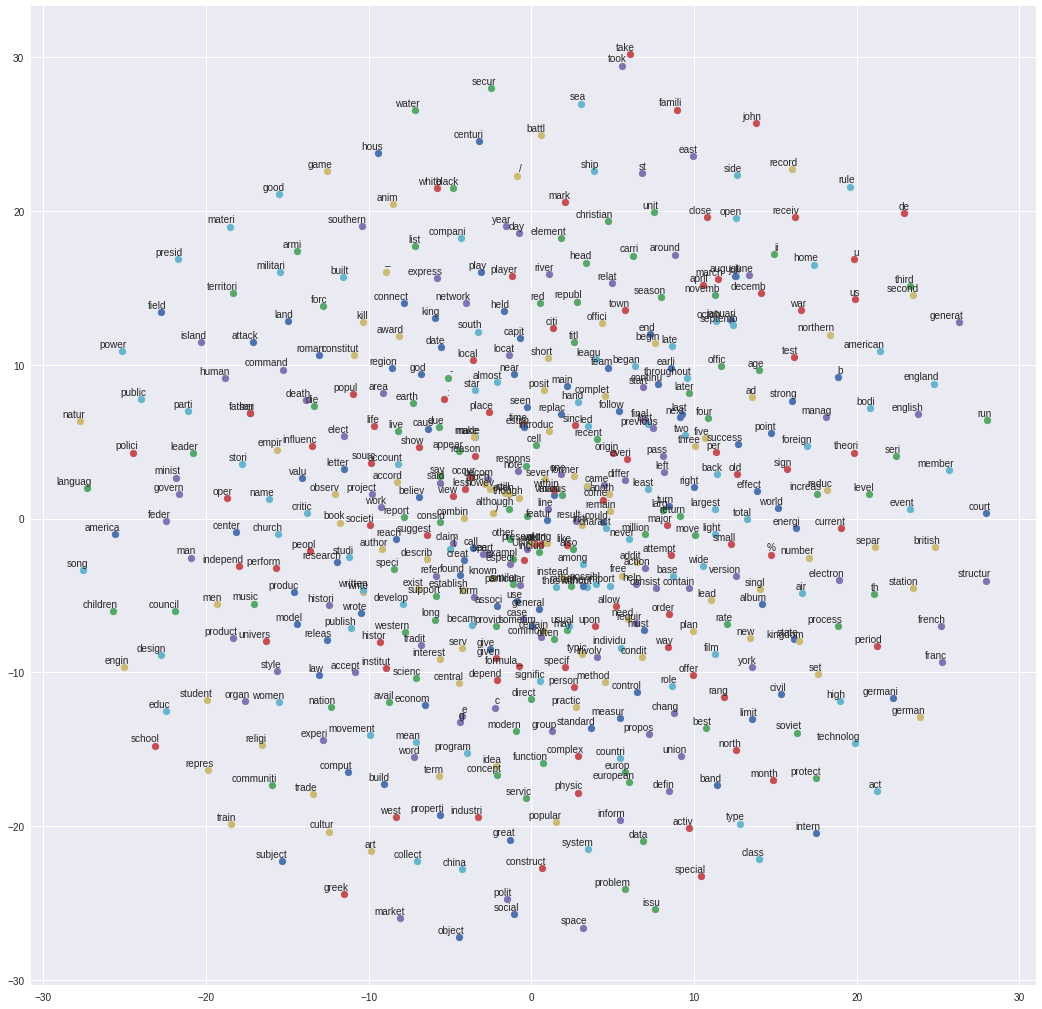

In [17]:
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(embed_mat[:plot_only, :])
labels = [int_to_vocab[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)